
# Practical session n°4 :

Notions:


*   Attentional layers
*   Multiple attentional heads
*   Standard toy tasks (Dyck validaty test, addition, parity test)




## Part I — Presentation of the Transformer architecture

In this part, you will:

1. See how a tiny Transformer is coded in PyTorch.
2. Focus on the attention layer: multi-head mechanism and the role of the Q, K, V matrices.
3. Estimate how many FLOPs are involved in a forward pass through a multi-head attention layer  
   (and compare with the theoretical considerations from the lesson).


In [1]:
# Imports & basic configuration

import math
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


Device: cpu


In [2]:
# Tiny Transformer building blocks (embedding + multi-head attention)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, L, D)
        L = x.size(1)
        return x + self.pe[:, :L, :]

class MultiHeadSelfAttention(nn.Module):
    """
    Minimal multi-head self-attention.
    If verbose=True, prints tensor shapes at key steps.
    """
    def __init__(self, d_model: int = 64, n_heads: int = 4, verbose: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.verbose = verbose

        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)

    def _vprint(self, name, x):
        if self.verbose:
            print(f"{name}: {tuple(x.shape)}")

    def forward(self, x):
        # x: (B, L, D)
        B, L, D = x.shape

        Q = self.Wq(x)  # (B, L, D)
        K = self.Wk(x)
        V = self.Wv(x)
        self._vprint("Q", Q)
        self._vprint("K", K)
        self._vprint("V", V)

        # reshape to heads
        Q = Q.view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # (B, H, L, Dh)
        K = K.view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        V = V.view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        self._vprint("Q_heads", Q)
        self._vprint("K_heads", K)
        self._vprint("V_heads", V)

        # scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B,H,L,L)
        self._vprint("scores", scores)

        attn = torch.softmax(scores, dim=-1)  # (B,H,L,L)
        self._vprint("attn_probs", attn)

        Z = torch.matmul(attn, V)  # (B,H,L,Dh)
        self._vprint("Z_heads", Z)

        # merge heads
        Z = Z.transpose(1, 2).contiguous().view(B, L, D)  # (B, L, D)
        self._vprint("Z_merged", Z)

        out = self.Wo(Z)  # (B, L, D)
        self._vprint("out", out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int = 64, n_heads: int = 4, mlp_ratio: int = 4):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads, verbose=False)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * mlp_ratio),
            nn.GELU(),
            nn.Linear(d_model * mlp_ratio, d_model),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyTransformer(nn.Module):
    """
    Tiny Transformer for sequence classification.
    """
    def __init__(self, vocab_size: int, d_model: int = 64, n_heads: int = 4, n_layers: int = 2, num_classes: int = 2):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.blocks = nn.ModuleList(
            [TransformerBlock(d_model=d_model, n_heads=n_heads) for _ in range(n_layers)]
        )
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (B, L) token ids
        h = self.tok_emb(x)
        h = self.pos_emb(h)
        for blk in self.blocks:
            h = blk(h)
        # use mean pooling for classification
        h = h.mean(dim=1)
        return self.head(h)


### Exercice 1 — Check embedding output size

Using `TinyTransformer`, define a random input batch of token ids with:

- batch size `B`
- sequence length `L`
- vocabulary size consistent with the model

Use `torch.randint` to generate this input and pass it **only through the embedding layer**.  
Verify that the output has shape `(B, L, d_model)`.

In [3]:
# Correction Exercice 1

B, L = 4, 10
vocab_size = 20
d_model = 64

model = TinyTransformer(vocab_size=vocab_size, d_model=d_model, n_heads=4, n_layers=2, num_classes=2)

x = torch.randint(low=0, high=vocab_size, size=(B, L))  # (B, L)
with torch.no_grad():
    emb_out = model.tok_emb(x)  # (B, L, d_model)

print("Input shape:", x.shape)
print("Embedding output shape:", emb_out.shape)



Input shape: torch.Size([4, 10])
Embedding output shape: torch.Size([4, 10, 64])


### Exercice 2 — Pass through MultiHeadSelfAttention (with verbose shapes)

1. Reuse the embedded tensor from Exercice 1 (or recreate it).
2. Instantiate a `MultiHeadSelfAttention` layer with `verbose=True`.
3. Pass the embeddings through it and observe the printed shapes at each step.

This is to **trace Q, K, V, heads, scores, and outputs**.


In [4]:
# Correction Exercice 2

B, L = 2, 6
vocab_size = 20
d_model = 64
n_heads = 4

x = torch.randint(0, vocab_size, (B, L))
emb = model.tok_emb(x)

attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads, verbose=True)
with torch.no_grad():
    out = attn(emb)

print("Final attention output shape:", out.shape)


Q: (2, 6, 64)
K: (2, 6, 64)
V: (2, 6, 64)
Q_heads: (2, 4, 6, 16)
K_heads: (2, 4, 6, 16)
V_heads: (2, 4, 6, 16)
scores: (2, 4, 6, 6)
attn_probs: (2, 4, 6, 6)
Z_heads: (2, 4, 6, 16)
Z_merged: (2, 6, 64)
out: (2, 6, 64)
Final attention output shape: torch.Size([2, 6, 64])


### Exercice 3 — Count FLOPs in multi-head self-attention

For a single multi-head self-attention layer with:

- sequence length `L`
- model dimension `d_model`
- number of heads `h` (each of size `d_head = d_model / h`)

1. Derive the approximate number of multiply-add operations for:
   - Q, K, V linear projections
   - Attention scores computation
   - Attention-weighted sum
   - Output projection
2. Identify the term that dominates when `L` is large, and explain why it is in `O(L² × d_model)`.

Complete the function below.


In [5]:
# Correction Exercice 3 & 4 — FLOPs estimates

def mhsa_flops(L, d_model, n_heads):
    """
    Rough FLOPs (multiply-adds counted as ~2 ops, but we keep a simple count).
    Returns a dict with contributions.
    """
    d_head = d_model // n_heads

    # Q, K, V projections: 3 * (L * d_model * d_model)
    qkv = 3 * L * d_model * d_model

    # scores = Q K^T: (B,H,L,Dh) x (B,H,Dh,L) -> (B,H,L,L)
    # ~ 2 * (H * L * L * Dh)
    scores = 2 * n_heads * (L * L * d_head)

    # attn @ V: (B,H,L,L) x (B,H,L,Dh) -> (B,H,L,Dh)
    # ~ 2 * (H * L * L * Dh)
    weighted = 2 * n_heads * (L * L * d_head)

    # output projection Wo: L * d_model * d_model
    wo = L * d_model * d_model

    return {
        "qkv": qkv,
        "scores": scores,
        "weighted": weighted,
        "wo": wo,
        "total": qkv + scores + weighted + wo,
    }

# Example: impact of L (show domination of L^2 * d_model terms)
for L in [16, 64, 256]:
    stats = mhsa_flops(L=L, d_model=64, n_heads=4)
    print(f"L={L} -> total={stats['total']:.2e}, scores+weighted={stats['scores']+stats['weighted']:.2e}")

print("\nObservation: for large L, the attention matrix computations (in L^2) dominate.")

# Exercice 4 — Example: FLOPs for a tiny Transformer on a batch
def tiny_transformer_flops(num_layers, L, d_model, n_heads, mlp_ratio=4):
    attn = mhsa_flops(L, d_model, n_heads)["total"]
    # MLP per layer: 2 linear layers: ~ 2 * L * d_model * (d_model * mlp_ratio)
    mlp = 2 * L * d_model * (d_model * mlp_ratio)
    per_layer = attn + mlp
    return num_layers * per_layer

print("\nTinyTransformer example (num_layers=2, L=64, d_model=64, n_heads=4):")
print(f"~ {tiny_transformer_flops(2, 64, 64, 4):.2e} FLOPs (rough order of magnitude)")


L=16 -> total=3.28e+05, scores+weighted=6.55e+04
L=64 -> total=2.10e+06, scores+weighted=1.05e+06
L=256 -> total=2.10e+07, scores+weighted=1.68e+07

Observation: for large L, the attention matrix computations (in L^2) dominate.

TinyTransformer example (num_layers=2, L=64, d_model=64, n_heads=4):
~ 8.39e+06 FLOPs (rough order of magnitude)


## Part II — A first example: Validation of Dyck-1 words

We now train models to decide if a word over `{ '(', ')' }` is a valid Dyck-1 word (balanced parentheses).

We start with a simple dataset **without distractors**.


In [6]:
# Dyck-1 dataset (no distractors)

VOCAB_DYCK = ['(', ')']
stoi_dyck = {c: i for i, c in enumerate(VOCAB_DYCK)}
itos_dyck = {i: c for c, i in stoi_dyck.items()}

def dyck1_valid_sequence(n_pairs):
    """
    Generate a uniformly random valid Dyck-1 sequence with n_pairs pairs.
    """
    seq = []
    depth = 0
    for _ in range(2 * n_pairs):
        if depth == 0:
            seq.append('(')
            depth += 1
        elif depth == (2 * n_pairs - len(seq)):
            seq.append(')')
            depth -= 1
        else:
            if random.random() < 0.5:
                seq.append('(')
                depth += 1
            else:
                seq.append(')')
                depth -= 1
    return ''.join(seq)

def is_valid_dyck1(s):
    depth = 0
    for ch in s:
        if ch == '(':
            depth += 1
        elif ch == ')':
            depth -= 1
        if depth < 0:
            return False
    return depth == 0

class DyckDataset(nn.Module):
    """
    Binary classification:
    y = 1 if valid Dyck-1, y = 0 otherwise.
    """
    def __init__(self, n_samples=2000, n_pairs=6):
        super().__init__()
        self.samples = []
        for _ in range(n_samples):
            s = dyck1_valid_sequence(n_pairs)
            # with prob 0.5 corrupt one char to create invalid string
            if random.random() < 0.5:
                y = 1
            else:
                s = list(s)
                pos = random.randrange(len(s))
                s[pos] = '(' if s[pos] == ')' else ')'
                s = ''.join(s)
                y = int(is_valid_dyck1(s))
                # if by chance it is valid, flip again
                if y == 1:
                    pos = (pos + 1) % len(s)
                    s = list(s)
                    s[pos] = '(' if s[pos] == ')' else ')'
                    s = ''.join(s)
                    y = int(is_valid_dyck1(s))
            x = torch.tensor([stoi_dyck[c] for c in s], dtype=torch.long)
            self.samples.append((x, torch.tensor(y, dtype=torch.long)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def dyck_collate(batch):
    xs, ys = zip(*batch)
    L = max(len(x) for x in xs)
    X = torch.full((len(xs), L), fill_value=0, dtype=torch.long)
    for i, x in enumerate(xs):
        X[i, :len(x)] = x
    Y = torch.stack(ys)
    return X, Y


### Exercice 5 — Inspect Dyck-1 samples

1. Build a `DyckDataset` with `n_pairs = 6`.
2. Print the first 5 sequences:
   - as indices
   - as corresponding parenthesis strings
   - with their labels (valid / invalid)
3. What is the size of the vocabulary for this problem?


In [7]:
# Correction Exercice 5

dyck_train = DyckDataset(n_samples=8, n_pairs=6)

for i in range(5):
    x, y = dyck_train[i]
    s = ''.join(itos_dyck[int(t)] for t in x)
    print(f"Sample {i}: indices={x.tolist()}  | word={s}  | label={int(y)}")

print("\nVocabulary:", VOCAB_DYCK)
print("Vocab size:", len(VOCAB_DYCK))


Sample 0: indices=[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]  | word=()())(()()))  | label=0
Sample 1: indices=[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]  | word=()(()((())))  | label=1
Sample 2: indices=[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]  | word=()()()()()()  | label=1
Sample 3: indices=[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]  | word=((((()(())))  | label=0
Sample 4: indices=[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]  | word=()(()(()(())  | label=0

Vocabulary: ['(', ')']
Vocab size: 2


### Exercice 6 — Training loop with history + learning curves

Complete a training loop that:

1. Trains a small Transformer on Dyck-1.
2. Stores training and validation accuracies at each epoch.
3. Plots both curves on the same figure.

Use the `TinyTransformer` from Part I (with `vocab_size = 2`).


In [8]:
# Training utilities (Transformer on Dyck-1) with history

def accuracy_from_logits(logits, y):
    return (logits.argmax(dim=-1) == y).float().mean().item()

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        loss.backward()
        optimizer.step()
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, Y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, Y) * bs
        n += bs
    return total_loss / n, total_acc / n


Epoch 1: train_acc=0.518, val_acc=0.500
Epoch 2: train_acc=0.488, val_acc=0.768
Epoch 3: train_acc=0.857, val_acc=1.000
Epoch 4: train_acc=1.000, val_acc=1.000
Epoch 5: train_acc=1.000, val_acc=1.000
Epoch 6: train_acc=1.000, val_acc=1.000
Epoch 7: train_acc=1.000, val_acc=1.000
Epoch 8: train_acc=1.000, val_acc=1.000


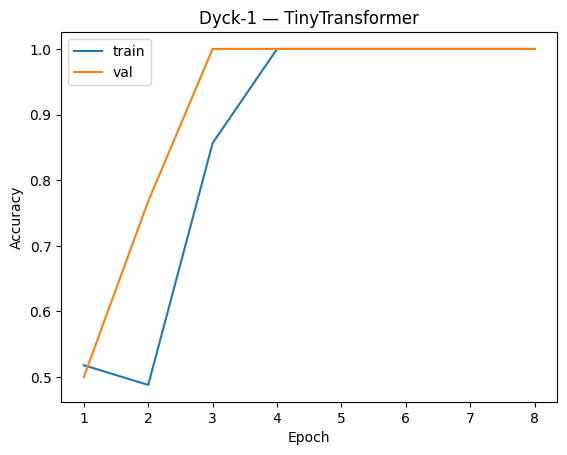

In [9]:
# Train Transformer on Dyck-1 and plot curves

from torch.utils.data import DataLoader

train_set = DyckDataset(n_samples=2000, n_pairs=6)
val_set   = DyckDataset(n_samples=500,  n_pairs=6)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=False)

model_tx = TinyTransformer(vocab_size=len(VOCAB_DYCK), d_model=64, n_heads=4, n_layers=2, num_classes=2).to(device)
opt = torch.optim.AdamW(model_tx.parameters(), lr=2e-3)

E = 8
train_accs, val_accs = [], []

for epoch in range(1, E+1):
    tr_loss, tr_acc = train_epoch(model_tx, train_loader, opt)
    va_loss, va_acc = eval_epoch(model_tx, val_loader)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    print(f"Epoch {epoch}: train_acc={tr_acc:.3f}, val_acc={va_acc:.3f}")

plt.figure()
plt.plot(range(1, E+1), train_accs, label="train")
plt.plot(range(1, E+1), val_accs, label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dyck-1 — TinyTransformer")
plt.legend()
plt.show()


In [24]:
mots = ["((()()))", "()()((()))", "(()))","(","()()()()()()()()()()()()()","(()","()()()()())((()())"]
for mot in mots:
  x = torch.tensor([stoi_dyck[c] for c in mot], dtype=torch.long)
  output = model_tx(x.unsqueeze(0).to(device))
  print(output)
  print(output.argmax(dim=-1))

# il a faux sur le dernier mot

tensor([[-5.6118,  8.5666]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-6.1811,  9.6582]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[ 4.6989, -9.9781]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[ 13.2564, -20.3090]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.1196,  7.7586]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[ 10.4819, -16.4210]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.6834,  7.2465]], grad_fn=<AddmmBackward0>)
tensor([1])


### Exercice 7 — Compare with a CNN baseline

1. Implement a 1D CNN below.
2. Train it on the same Dyck-1 dataset.
3. Compare its validation accuracy and behavior with the Transformer.

Use the correction cell below only after you have tried.


In [10]:
# Correction Exercice 7 — Simple CNN baseline on Dyck-1

class DyckCNN(nn.Module):
    def __init__(self, vocab_size=2, emb_dim=32, num_classes=2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(emb_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.head = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, L)
        e = self.emb(x).transpose(1, 2)  # (B,C,L)
        h = F.relu(self.conv1(e))
        h = F.relu(self.conv2(h))
        h = h.mean(dim=-1)               # global average pooling
        return self.head(h)

cnn = DyckCNN(vocab_size=len(VOCAB_DYCK), emb_dim=32, num_classes=2).to(device)
opt_cnn = torch.optim.AdamW(cnn.parameters(), lr=2e-3)

E = 8
for epoch in range(1, E+1):
    tr_loss, tr_acc = train_epoch(cnn, train_loader, opt_cnn)
    va_loss, va_acc = eval_epoch(cnn, val_loader)
    print(f"[CNN] Epoch {epoch}: train_acc={tr_acc:.3f}, val_acc={va_acc:.3f}")


[CNN] Epoch 1: train_acc=0.516, val_acc=0.618
[CNN] Epoch 2: train_acc=0.537, val_acc=0.500
[CNN] Epoch 3: train_acc=0.543, val_acc=0.598
[CNN] Epoch 4: train_acc=0.574, val_acc=0.622
[CNN] Epoch 5: train_acc=0.606, val_acc=0.640
[CNN] Epoch 6: train_acc=0.625, val_acc=0.678
[CNN] Epoch 7: train_acc=0.632, val_acc=0.660
[CNN] Epoch 8: train_acc=0.640, val_acc=0.614


## Part III — Addition and Parity tasks

### Exercice 11

Use the following synthetic datasets to train and compare models
(Transformers and CNNs) on:

1. **Addition**: predict the last digit of `a + b` from an input like `"123+45="`.
2. **Parity**: predict the parity (0/1) of a binary string.

Reuse your training utilities from Part II.


In [11]:
# Addition & Parity datasets

# --- Addition ---
DIGITS = [str(i) for i in range(10)]
ADD_VOCAB = DIGITS + ['+', '=']
add_stoi = {c: i for i, c in enumerate(ADD_VOCAB)}

def gen_add_sample(n1_digits=3, n2_digits=3):
    """
    Input:  string representation "a+b=".
    Target: last digit of (a + b).
    """
    a = random.randint(0, 10**n1_digits - 1)
    b = random.randint(0, 10**n2_digits - 1)
    s = f"{a}+{b}="
    x = torch.tensor([add_stoi[c] for c in s], dtype=torch.long)
    y = (a + b) % 10
    return x, torch.tensor(y, dtype=torch.long)

class AddDataset(torch.utils.data.Dataset):
    def __init__(self, n, n1_digits=3, n2_digits=3):
        self.samples = [gen_add_sample(n1_digits, n2_digits) for _ in range(n)]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

def add_collate(batch):
    xs, ys = zip(*batch)
    L = max(len(x) for x in xs)
    X = torch.full((len(xs), L), fill_value=0, dtype=torch.long)
    for i, x in enumerate(xs):
        X[i, :len(x)] = x
    Y = torch.stack(ys)
    return X, Y

# --- Parity ---
BIN_VOCAB = ['0', '1']
bin_stoi = {c: i for i, c in enumerate(BIN_VOCAB)}

def gen_parity_sample(L=32):
    """
    Input:  random binary string of length L.
    Target: parity of number of '1's (0 = even, 1 = odd).
    """
    s = ''.join(random.choice(BIN_VOCAB) for _ in range(L))
    x = torch.tensor([bin_stoi[c] for c in s], dtype=torch.long)
    y = s.count('1') % 2
    return x, torch.tensor(y, dtype=torch.long)

class ParityDataset(torch.utils.data.Dataset):
    def __init__(self, n, L=32):
        self.samples = [gen_parity_sample(L) for _ in range(n)]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

def parity_collate(batch):
    xs, ys = zip(*batch)
    L = max(len(x) for x in xs)
    X = torch.full((len(xs), L), fill_value=0, dtype=torch.long)
    for i, x in enumerate(xs):
        X[i, :len(x)] = x
    Y = torch.stack(ys)
    return X, Y


In [12]:
# Reusable training helper (supports different num_classes)

def train_model_classifier(model, train_loader, val_loader, epochs=6, lr=2e-3, name="model"):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val = 0.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, opt)
        va_loss, va_acc = eval_epoch(model, val_loader)
        if va_acc > best_val:
            best_val = va_acc
        print(f"[{name}] Epoch {ep}: train_acc={tr_acc:.3f}, val_acc={va_acc:.3f}")
    print(f"[{name}] best_val_acc={best_val:.3f}")
    return model


In [25]:
"".join([ADD_VOCAB[x.item()] for x in train_add[0][0]])

'346+859='

In [ ]:
# Example usage: TinyTransformer on Addition & Parity

# Addition
train_add = AddDataset(n=4000)
val_add   = AddDataset(n=1000)

train_add_loader = torch.utils.data.DataLoader(train_add, batch_size=64, shuffle=True,  collate_fn=add_collate)
val_add_loader   = torch.utils.data.DataLoader(val_add,   batch_size=64, shuffle=False, collate_fn=add_collate)

tx_add = TinyTransformer(vocab_size=len(ADD_VOCAB), d_model=64, n_heads=4, n_layers=2, num_classes=10)
train_model_classifier(tx_add, train_add_loader, val_add_loader, epochs=6, name="Transformer-Add")

# Parity
train_par = ParityDataset(n=4000, L=64)
val_par   = ParityDataset(n=1000, L=64)

train_par_loader = torch.utils.data.DataLoader(train_par, batch_size=64, shuffle=True,  collate_fn=parity_collate)
val_par_loader   = torch.utils.data.DataLoader(val_par,   batch_size=64, shuffle=False, collate_fn=parity_collate)

tx_par = TinyTransformer(vocab_size=len(BIN_VOCAB), d_model=64, n_heads=4, n_layers=2, num_classes=2)
train_model_classifier(tx_par, train_par_loader, val_par_loader, epochs=300, lr=2e-4, name="Transformer-Parity")


[Transformer-Add] Epoch 1: train_acc=0.104, val_acc=0.096
[Transformer-Add] Epoch 2: train_acc=0.127, val_acc=0.117
[Transformer-Add] Epoch 3: train_acc=0.161, val_acc=0.168
[Transformer-Add] Epoch 4: train_acc=0.205, val_acc=0.205
[Transformer-Add] Epoch 5: train_acc=0.397, val_acc=0.601
[Transformer-Add] Epoch 6: train_acc=0.753, val_acc=0.835
[Transformer-Add] best_val_acc=0.835
[Transformer-Parity] Epoch 1: train_acc=0.502, val_acc=0.510
[Transformer-Parity] Epoch 2: train_acc=0.499, val_acc=0.510
[Transformer-Parity] Epoch 3: train_acc=0.505, val_acc=0.510
[Transformer-Parity] Epoch 4: train_acc=0.498, val_acc=0.510
[Transformer-Parity] Epoch 5: train_acc=0.508, val_acc=0.490
[Transformer-Parity] Epoch 6: train_acc=0.501, val_acc=0.490
[Transformer-Parity] Epoch 7: train_acc=0.500, val_acc=0.510
[Transformer-Parity] Epoch 8: train_acc=0.511, val_acc=0.510
[Transformer-Parity] Epoch 9: train_acc=0.495, val_acc=0.510
[Transformer-Parity] Epoch 10: train_acc=0.508, val_acc=0.496
[Tra